### Read All the excel files

In [58]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [59]:
def read_file(file_path):
    file_extension = file_path.suffix.lower()[1:]

    try:
        if file_extension == 'xlsx':
            # Read all sheets from the Excel file
            df_dict = pd.read_excel(file_path, sheet_name=None, engine='openpyxl')  # sheet_name=None reads all sheets
            sheet_names = list(df_dict.keys())  # Get the list of all sheet names
        elif file_extension == 'xls':
            # Read all sheets from the older Excel format
            df_dict = pd.read_excel(file_path, sheet_name=None)  # sheet_name=None reads all sheets
            sheet_names = list(df_dict.keys())  # Get the list of all sheet names
        else:
            print(f"File format not supported: {file_path}")
            return None, []

        print(f"Successfully read file: {file_path}")
        return df_dict, sheet_names
    except UnicodeDecodeError:
        print(f"Error reading {file_path} with utf-8. Trying with ISO-8859-1 encoding.")
        try:
            df_dict = {file_path.stem: pd.read_csv(file_path, encoding='ISO-8859-1')}
            return df_dict, [file_path.stem]
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None, []
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, []

def process_files_in_folder(folder_path):
    folder = Path(folder_path)
    all_data = {}  # Dictionary to store all file and sheet data
    file_sheet_map = {}  # Dictionary to store all file names and their corresponding sheet names

    if not folder.exists():
        print(f"Folder does not exist: {folder_path}")
        return
    
    for file in folder.iterdir():
        if file.exists() and file.is_file() and file.suffix.lower() in ['.xlsx', '.xls', '.csv']:
            file_name_without_extension = file.stem  # Get the file name without the extension
            file_name_without_extension = file.stem.replace("Report", "").strip()
            print(f"Processing file: {file.name}")
            df_dict, sheet_names = read_file(file)
            if df_dict is not None:
                # Store the dataframe and sheet names using the file name without the extension
                all_data[file_name_without_extension] = df_dict
                file_sheet_map[file_name_without_extension] = sheet_names
            else:
                print(f"Skipping {file.name} due to an error.")
        else:
            print(f"File not found or unsupported format: {file.name}")
    
    return all_data, file_sheet_map

# Example usage
folder_path = 'Reports/'  # Replace with your actual folder path
all_data, file_sheet_map = process_files_in_folder(folder_path)

# Access all the data (file -> sheet -> DataFrame)
print("Files and their corresponding sheets:")
for file_name, sheet_names in file_sheet_map.items():
    print(f"File: {file_name} -> Sheets: {sheet_names}")


Processing file: Marc O Polo Report.xlsx
Successfully read file: Reports/Marc O Polo Report.xlsx
File not found or unsupported format: .DS_Store
Processing file: Burberry Report.xlsx
Successfully read file: Reports/Burberry Report.xlsx
Processing file: LVMH Group Report.xlsx
Successfully read file: Reports/LVMH Group Report.xlsx
Processing file: Porsche Report.xlsx
Successfully read file: Reports/Porsche Report.xlsx
Processing file: PVH Corp Report.xlsx
Successfully read file: Reports/PVH Corp Report.xlsx
Processing file: Adidas Report.xlsx
Successfully read file: Reports/Adidas Report.xlsx
Processing file: Ralph Lauren Report.xlsx
Successfully read file: Reports/Ralph Lauren Report.xlsx
Processing file: Mercedes Benz AG Report.xlsx
Successfully read file: Reports/Mercedes Benz AG Report.xlsx
Processing file: Giorgio Armani Report.xlsx
Successfully read file: Reports/Giorgio Armani Report.xlsx
Processing file: Bosch Report.xlsx
Successfully read file: Reports/Bosch Report.xlsx
Files an

In [60]:
len(all_data)

10

In [61]:
# Check the structure of company movement df
all_data['Marc O Polo']['Company Movements']

,Company,Departures,Hires,Ratio,Net change
0,HUGO BOSS,8,1,-8,-7
1,H&M,0,4,4,4
2,HALLHUBER,0,4,4,4
3,PUMA Group,1,3,3,2
4,BMW Group,1,2,2,1
...,...,...,...,...,...
95,LPJ Studios,0,1,1,1
96,Haas Fertigbau Deutschland,0,1,1,1
97,Biofabrik Technologies GmbH,0,1,1,1
98,ECCO,0,1,1,1


### Filter out for HUGO BOSS for company movements

         Competitor    Company  Moved to HUGO BOSS  Hired from HUGO BOSS  \
2        LVMH Group  HUGO BOSS                  17                    32   
8    Giorgio Armani  HUGO BOSS                   3                    10   
1          Burberry  HUGO BOSS                   4                     8   
3           Porsche  HUGO BOSS                   3                     5   
6      Ralph Lauren  HUGO BOSS                   6                     7   
5            Adidas  HUGO BOSS                   6                     6   
7  Mercedes Benz AG  HUGO BOSS                   5                     5   
9             Bosch  HUGO BOSS                   6                     2   
4          PVH Corp  HUGO BOSS                  10                     4   
0       Marc O Polo  HUGO BOSS                   8                     1   

   Net Change  
2          15  
8           7  
1           4  
3           2  
6           1  
5           0  
7           0  
9          -4  
4          -6  
0  

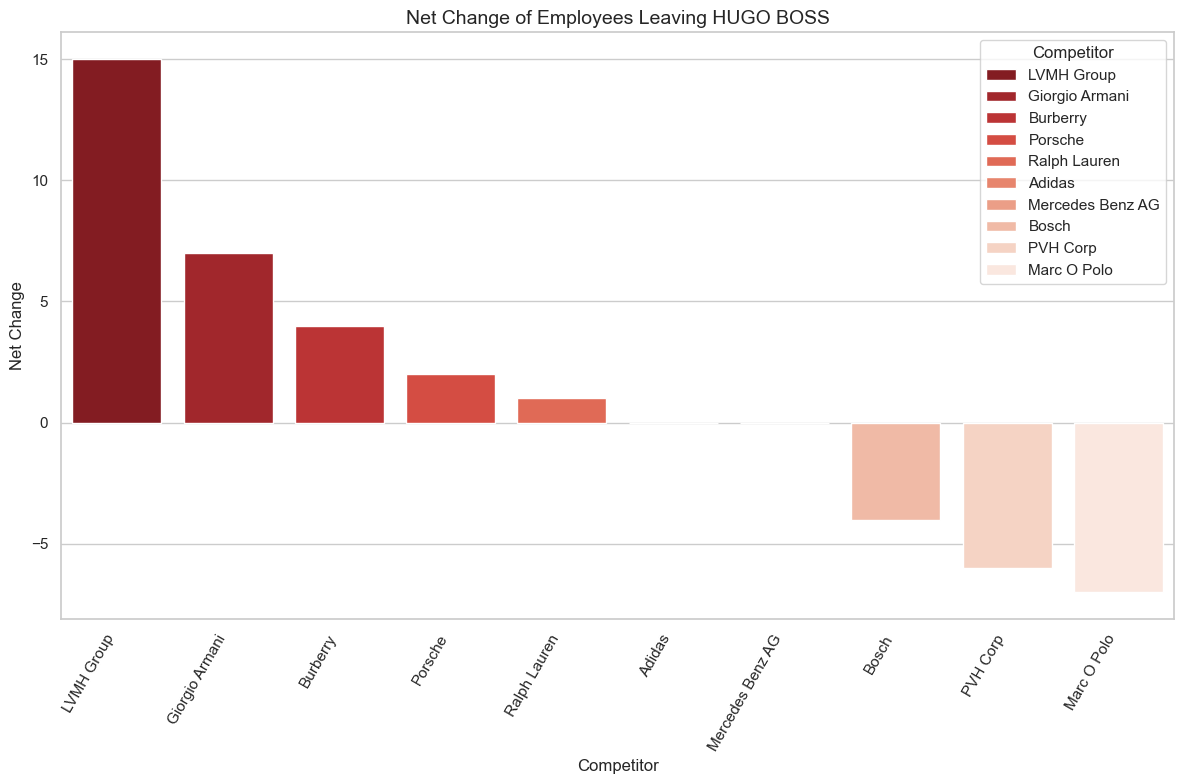

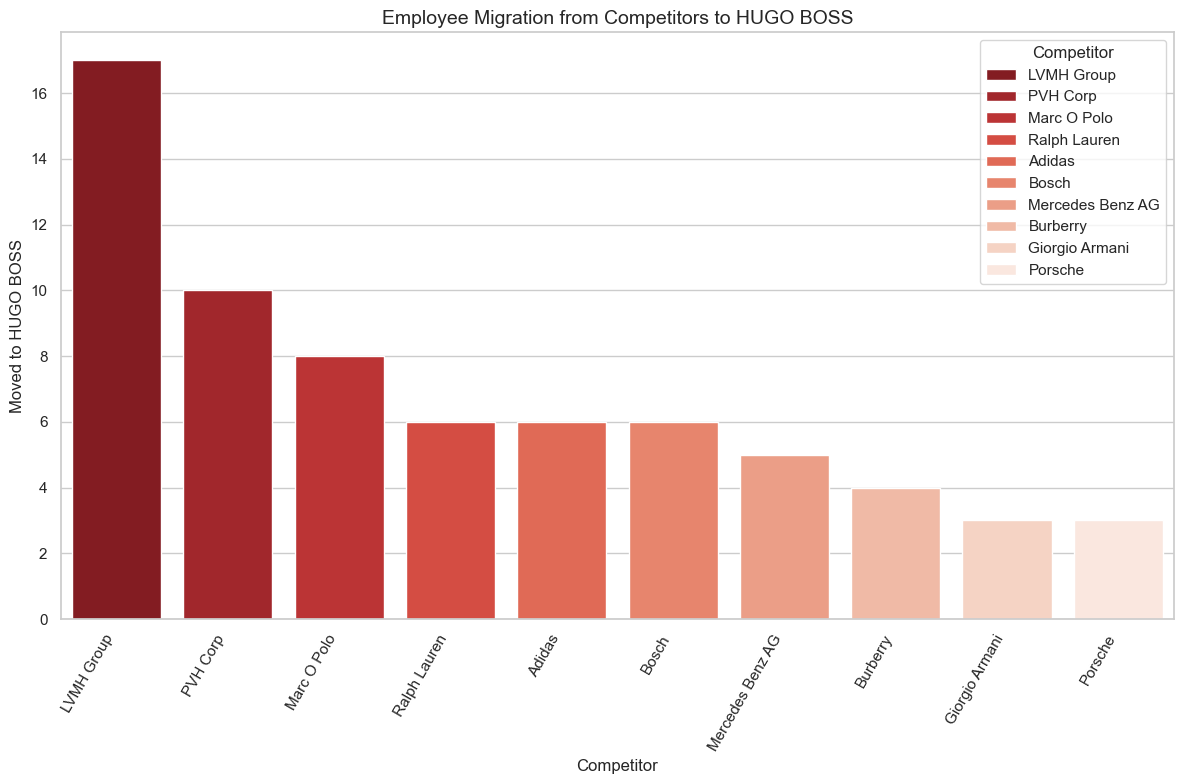

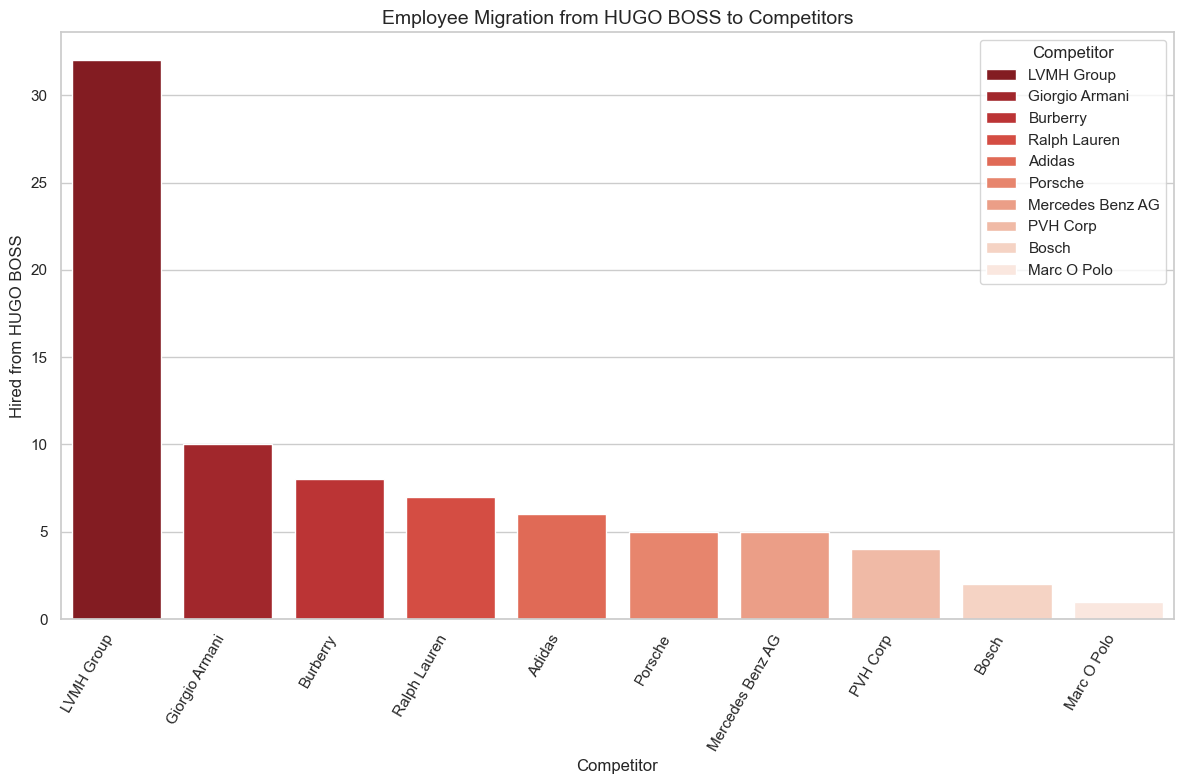

In [62]:
def search_company_in_sheets(all_data, company_name):
    results = []

    for file_name, sheets in all_data.items():
        for sheet_name, df in sheets.items():
            # Check if 'Company' column exists in the sheet
            if 'Company' in df.columns:
                # Filter rows where 'Company' column matches the company_name
                company_row = df[df['Company'] == company_name]

                if not company_row.empty:
                    # Get the 'Departures', 'Hires', and 'Net change' columns
                    departures = company_row['Departures'].values[0] if 'Departures' in company_row.columns else None
                    hires = company_row['Hires'].values[0] if 'Hires' in company_row.columns else None
                    net_change = company_row['Net change'].values[0] if 'Net change' in company_row.columns else None

                    results.append({
                        'Competitor': file_name,
                        'Company': company_name,
                        'Moved to HUGO BOSS': departures,
                        'Hired from HUGO BOSS': hires,
                        'Net Change': net_change
                    })

    return pd.DataFrame(results)

# Search for 'HUGO BOSS'
company_name_to_search = 'HUGO BOSS'
search_results_df = search_company_in_sheets(all_data, company_name_to_search)

# Sort and display the DataFrame by Net Change
result_df = search_results_df.sort_values(by='Net Change', ascending=False).head(10)
print(result_df)

def plot_metrics(df):
    """
    This function creates bar charts for 'Net Change', 'Departures', and 'Hires'.
    
    Parameters:
    - df: A Pandas DataFrame containing the sorted results with 'Net Change', 'Departures', and 'Hires'.
    """
    # Define a mapping between column names and custom chart titles
    metric_title_map = {
        'Net Change': 'Net Change of Employees Leaving HUGO BOSS',
        'Moved to HUGO BOSS': 'Employee Migration from Competitors to HUGO BOSS',
        'Hired from HUGO BOSS': 'Employee Migration from HUGO BOSS to Competitors'
    }
    
    # Set the figure size and style
    sns.set(style="whitegrid")
    
    for metric, title in metric_title_map.items():
        # Create a sorted DataFrame based on the current metric
        df_sorted = df.sort_values(by=metric, ascending=False)
        
        # Create the barplot for the current metric
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='Competitor', y=metric, data=df_sorted, palette="Reds_r", hue='Competitor', dodge=False)
        
        # Customize the labels and title
        plt.xlabel('Competitor', fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.title(f'{title}', fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
        
        # Show the plot
        plt.tight_layout()
        plt.show()

# Call the function to plot for departures, hires, and net change
plot_metrics(result_df)


In [63]:
# Convert to csv file
search_results_df.to_csv('Hugo_Boss_Attrition.csv',index=False)

### Visualizing Attrition Data for Multiple Competitors

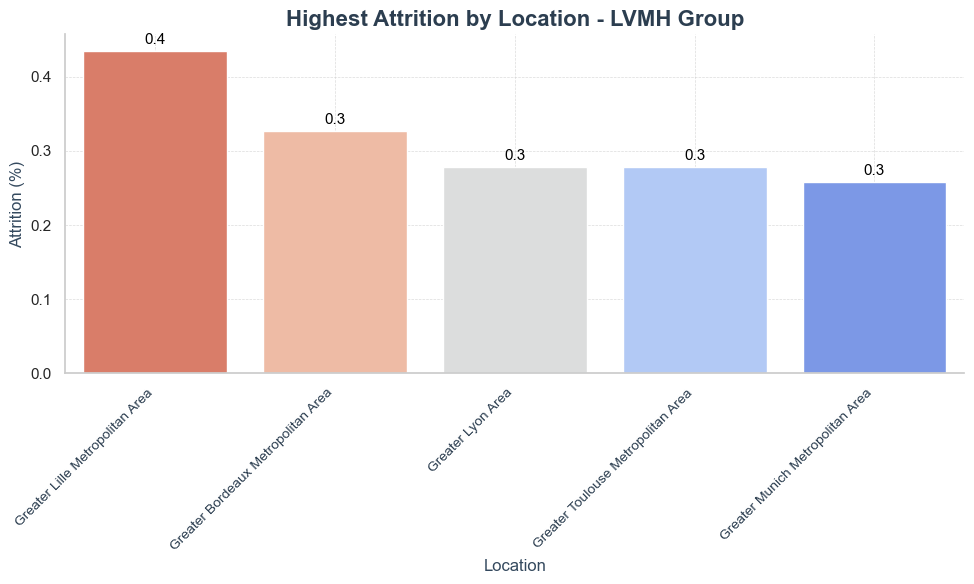

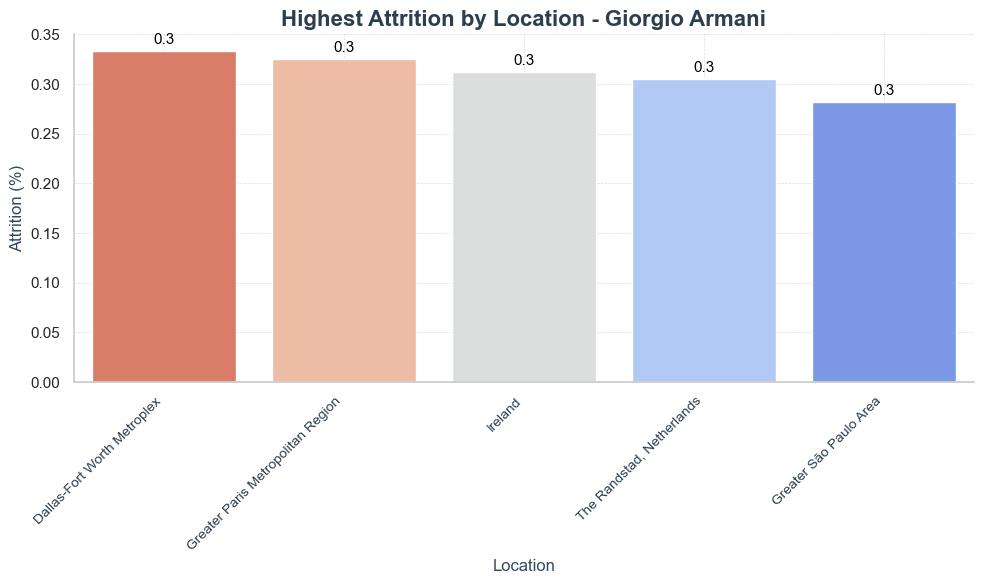

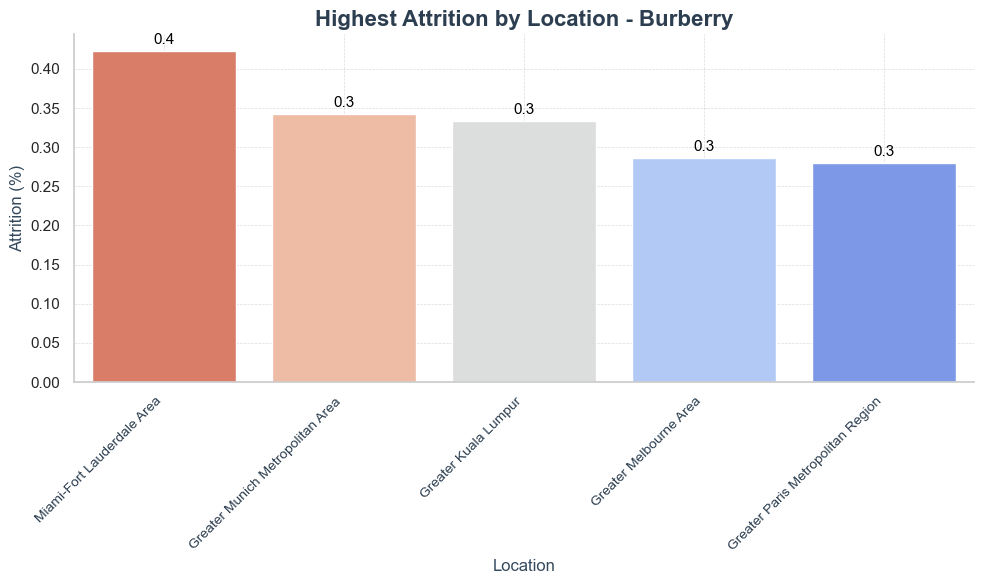

In [64]:
def plot_attrition_by_location(company_data, company_name):
    """
    This function creates a bar chart showing the highest attrition by location for a given company.
    
    Parameters:
    - company_data: A Pandas DataFrame containing the data for a specific company.
    - company_name: The name of the company (for title and labeling).
    """
    # Sort the data by 'Attrition' in descending order and select the top 5 locations
    df_sorted = company_data.sort_values(by='Attrition', ascending=False).head(5)
    
    # Create the plot with a darker style and a more refined color palette
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Location', y='Attrition', data=df_sorted, palette='coolwarm_r', saturation=0.8)

    # Add labels and title with a modern font
    plt.title(f'Highest Attrition by Location - {company_name}', fontsize=16, fontweight='bold', color='#2C3E50')
    plt.xlabel('Location', fontsize=12, color='#34495E')
    plt.ylabel('Attrition (%)', fontsize=12, color='#34495E')

    # Style the x-tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, color='#2C3E50')
    
    # Add gridlines and make the chart cleaner
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Remove the top and right borders (spines) for a minimalist look
    sns.despine()

    # Add data labels on top of the bars for clarity
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=11, color='black', xytext=(0, 5), 
                    textcoords='offset points')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming you have the attrition data for LVMH, Armani, and Burberry in separate dataframes:
lvmh_attrition = all_data['LVMH Group']['Attrition by Locations']  # Replace with actual sheet name
armani_attrition = all_data['Giorgio Armani']['Attrition by Locations']  # Replace with actual sheet name
burberry_attrition = all_data['Burberry']['Attrition by Locations']  # Replace with actual sheet name

# Call the function to plot attrition for each company
plot_attrition_by_location(lvmh_attrition, 'LVMH Group')
plot_attrition_by_location(armani_attrition, 'Giorgio Armani')
plot_attrition_by_location(burberry_attrition, 'Burberry')


In [65]:
all_data['LVMH Group']['Fields of Study']

,Fields of study,Employees,1y growth,1y hires,% of employees,HUGO BOSS %
0,Marketing,8808,0.039169,2695,0.055980,0.032144
1,"Business Administration and Management, General",8158,0.038971,2393,0.051849,0.052620
2,Economics,5721,0.039993,2161,0.036360,0.028915
3,"Business/Commerce, General",3932,0.049373,1273,0.024990,0.026714
4,Fashion/Apparel Design,3155,0.038512,1049,0.020052,0.036915
...,...,...,...,...,...,...
94,Auditing,328,0.018634,84,0.002085,0.000954
95,Chinese Studies,321,0.028846,90,0.002040,0.001101
96,Computer Systems Networking and Telecommunicat...,320,0.003135,59,0.002034,0.001248
97,"Biology/Biological Sciences, General",318,0.049505,101,0.002021,0.000807


In [66]:
all_data['LVMH Group']['Degrees']

,Degree,LVMH,Industry,HUGO BOSS
0,Master of Business Administration,0.102530,0.105717,0.096895
1,Master's Degree,0.390310,0.303081,0.329497
2,Associate's Degree,0.066094,0.055132,0.046039
3,Bachelor's Degree,0.432060,0.523778,0.518469
4,Doctor of Philosophy,0.009007,0.012292,0.009101


In [67]:
all_data['LVMH Group']['Skills']

,Skills,Employees,1y growth,1y hires,Job posts,% of employees,HUGO BOSS %
0,Merchandising,27307,0.011146,6090,639,0.173552,0.179657
1,Luxury Goods,26288,-0.000570,4802,58,0.167076,0.057097
2,Fashion,23150,0.024155,5188,196,0.147132,0.279613
3,Jewelry,21985,0.002417,3549,91,0.139727,0.018641
4,Consumer Services,21748,0.012760,4894,0,0.138221,0.104579
...,...,...,...,...,...,...,...
95,Brand Development,3343,-0.010947,625,5,0.021247,0.014311
96,Accounting,3343,0.060596,1031,85,0.021247,0.016953
97,Digital Technology,3313,0.017506,1215,73,0.021056,0.002715
98,In-Store Marketing,3310,-0.009279,823,296,0.021037,0.012036


### Extracting 'Skills' Data for LVMH Group

              Skills  Employees  1y growth  1y hires  Job posts  \
0      Merchandising      27307   0.011146      6090        639   
1       Luxury Goods      26288  -0.000570      4802         58   
2            Fashion      23150   0.024155      5188        196   
3            Jewelry      21985   0.002417      3549         91   
4  Consumer Services      21748   0.012760      4894          0   

   % of employees  HUGO BOSS %  
0        0.173552     0.179657  
1        0.167076     0.057097  
2        0.147132     0.279613  
3        0.139727     0.018641  
4        0.138221     0.104579  
Top 10 Skills at LV:
                 Skills  Employees  1y growth  1y hires  Job posts  \
0         Merchandising      27307   0.011146      6090        639   
1          Luxury Goods      26288  -0.000570      4802         58   
2               Fashion      23150   0.024155      5188        196   
3               Jewelry      21985   0.002417      3549         91   
4     Consumer Services     

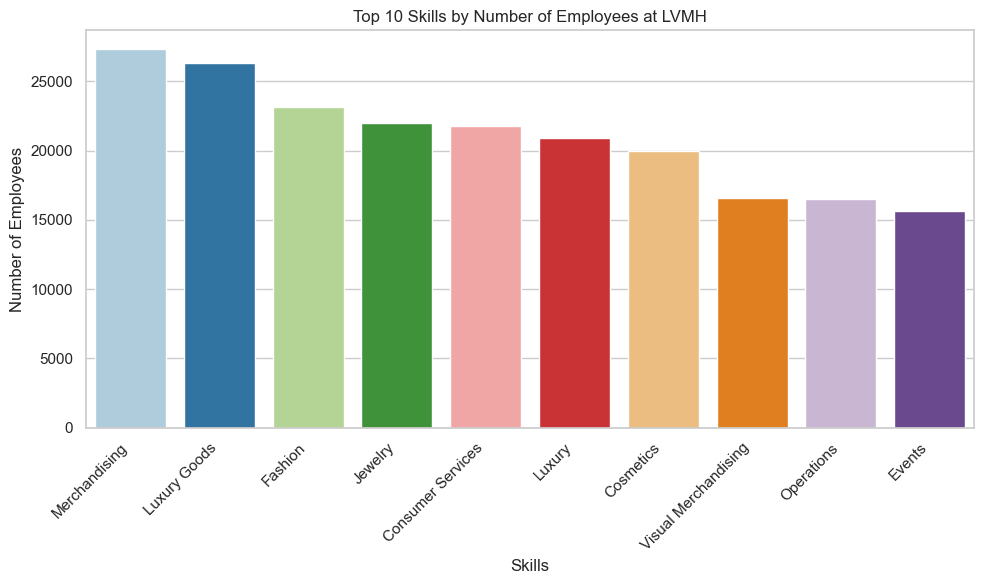

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 'Skills' subsheet for LV from all_data
skills_data = all_data['LVMH Group']['Skills'] 
# Display the first few rows to understand the structure
print(skills_data.head())

# Sort by the number of employees and get the top 10 skills
top_10_skills = skills_data.sort_values(by='Employees', ascending=False).head(10)

# Display the top 10 skills
print("Top 10 Skills at LV:")
print(top_10_skills[['Skills', 'Employees', '1y growth', '1y hires', 'Job posts', '% of employees', 'HUGO BOSS %']])

# Plot 1: Number of employees by top 10 skills
plt.figure(figsize=(10, 6))
sns.barplot(x='Skills', y='Employees', data=top_10_skills, palette='Paired')
plt.title('Top 10 Skills by Number of Employees at LVMH')
plt.xlabel('Skills')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [69]:
all_data['LVMH Group']['Attrition by Locations']

,Location,Attrition,HUGO BOSS attrition,% of employees
0,Greater Paris Metropolitan Region,0.202024,0.280840,0.154828
1,New York City Metropolitan Area,0.151592,0.231183,0.047406
2,United Arab Emirates,0.118835,0.129310,0.025448
3,Los Angeles Metropolitan Area,0.118314,0.090226,0.024361
4,"London Area, United Kingdom",0.192808,0.174589,0.023369
...,...,...,...,...
95,Greater Tampa Bay Area,0.124197,NaN,0.001608
96,"Épernay, Grand Est, France",0.047516,NaN,0.001595
97,"Saint-Jean-de-Braye, Centre-Val de Loire, France",0.048780,NaN,0.001583
98,Greater Turin Metropolitan Area,0.150628,NaN,0.001576


In [70]:
all_data['LVMH Group']['Location Movements']

,Location,Departures,Hires,Ratio,Net change
0,Greater Paris Metropolitan Region,4721,7073,1.498200,2352
1,New York City Metropolitan Area,1102,1525,1.383848,423
2,"London Area, United Kingdom",689,940,1.364296,251
3,United Arab Emirates,453,889,1.962472,436
4,Greater Milan Metropolitan Area,515,782,1.518447,267
...,...,...,...,...,...
107,Greater Edinburgh Area,35,40,1.142857,5
108,Greater Marbella Metropolitan Area,31,41,1.322581,10
109,Greater Tours Area,35,35,1.000000,0
110,Greater Hyderabad Area,8,60,7.500000,52


### Filtering Data for HUGO BOSS Attrition by Location

In [71]:
# Here we extract data from all relevant company files
lvmh_attrition = all_data['LVMH Group']['Attrition by Locations']
armani_attrition = all_data['Giorgio Armani']['Attrition by Locations']
burberry_attrition = all_data['Burberry']['Attrition by Locations']
porsche_attrition = all_data['Porsche']['Attrition by Locations']

# Step 1: Combine the attrition data into a single DataFrame
combined_attrition = pd.concat([lvmh_attrition.assign(Company='LVMH'),
                                armani_attrition.assign(Company='Armani'),
                                burberry_attrition.assign(Company='Burberry'),
                                porsche_attrition.assign(Company='Porsche')])

# Step 2: Filter the data to focus on HUGO BOSS attrition
hugo_boss_attrition = combined_attrition[['Location', 'Attrition' ,'HUGO BOSS attrition', 'Company']]

# Step 3: Sort by HUGO BOSS attrition in descending order
hugo_boss_attrition = hugo_boss_attrition.sort_values(by='HUGO BOSS attrition', ascending=False)

# Step 4: Drop duplicates based on the 'Location' column, keeping the first entry (highest attrition)
# Keep only the location with the highest HUGO BOSS attrition
hugo_boss_attrition_no_duplicates = hugo_boss_attrition.drop_duplicates(subset='Location', keep='first')

# Step 5: Display the top 5 locations by HUGO BOSS attrition
top_5_hugo_boss_attrition = hugo_boss_attrition_no_duplicates.head(5)
print("Top 5 Locations by HUGO BOSS Attrition (after removing duplicates based on highest attrition):")
print(top_5_hugo_boss_attrition)


Top 5 Locations by HUGO BOSS Attrition (after removing duplicates based on highest attrition):
                            Location  Attrition  HUGO BOSS attrition  Company
32          Zürich Metropolitan Area   0.363636             0.422018  Porsche
40                 Greater Lyon Area   0.278777             0.390805     LVMH
1             Greater Karlsruhe Area   0.207283             0.349206  Porsche
57  Greater Munich Metropolitan Area   0.258440             0.342541     LVMH
13             Greater Freiburg Area   0.370968             0.341463  Porsche


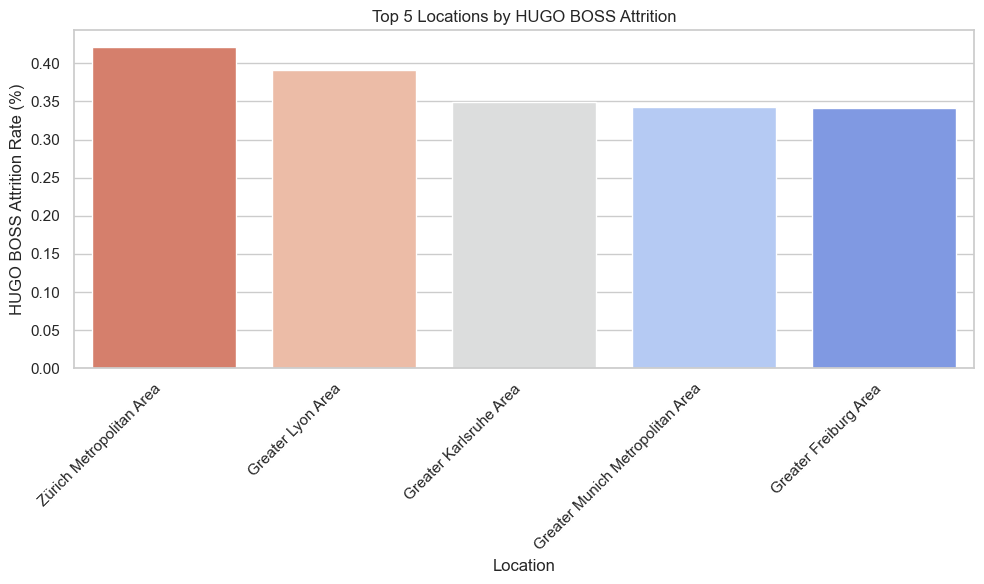

In [72]:
# Plot: HUGO BOSS Attrition by Location
plt.figure(figsize=(10, 6))
sns.barplot(x='Location', y='HUGO BOSS attrition', data=top_5_hugo_boss_attrition, palette='coolwarm_r')
plt.title('Top 5 Locations by HUGO BOSS Attrition')
plt.xlabel('Location')
plt.ylabel('HUGO BOSS Attrition Rate (%)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



Hires and Departures by Location and Company:
                             Location   Company  Hires  Departures  Net change
21                  Greater Lyon Area      LVMH    234         155          79
41   Greater Munich Metropolitan Area      LVMH    133         111          22
81           Zürich Metropolitan Area      LVMH     71          46          25
13   Greater Munich Metropolitan Area    Armani      9          11          -2
81           Zürich Metropolitan Area    Armani      2           2           0
91                  Greater Lyon Area    Armani      2           1           1
34   Greater Munich Metropolitan Area  Burberry      8           6           2
64           Zürich Metropolitan Area  Burberry      2           4          -2
95                  Greater Lyon Area  Burberry      2           1           1
1              Greater Karlsruhe Area   Porsche    290         148         142
2    Greater Munich Metropolitan Area   Porsche    142          94          48
10   

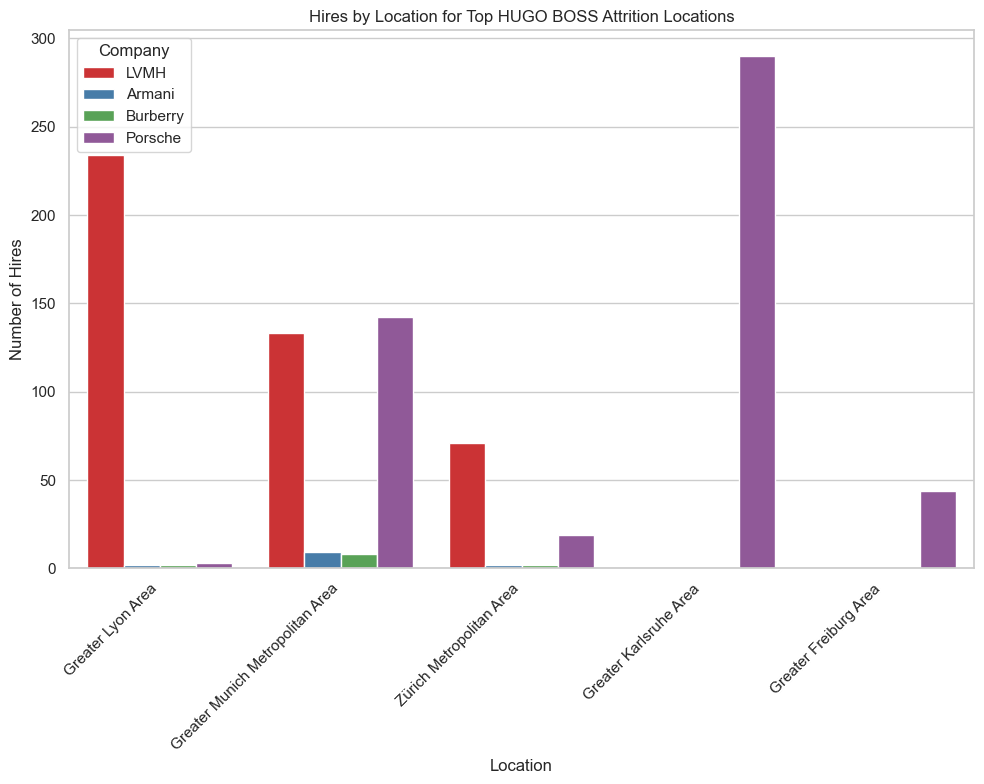

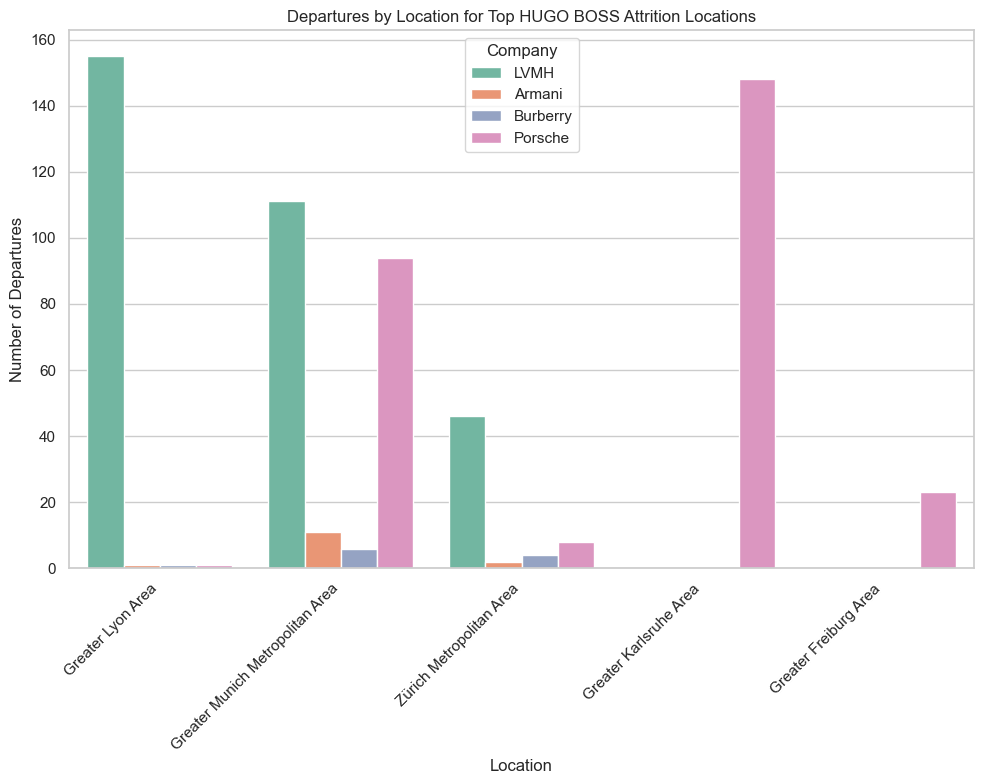

In [73]:
# Step 1: Extract Location Movement data from each company
lvmh_movement = all_data['LVMH Group']['Location Movements']
armani_movement = all_data['Giorgio Armani']['Location Movements']
burberry_movement = all_data['Burberry']['Location Movements']
porsche_movement = all_data['Porsche']['Location Movements']

# Step 2: Combine the movement data for all companies into one DataFrame
movement_data = pd.concat([lvmh_movement.assign(Company='LVMH'),
                           armani_movement.assign(Company='Armani'),
                           burberry_movement.assign(Company='Burberry'),
                           porsche_movement.assign(Company='Porsche')])

# Step 3: Filter the movement data to focus on the top locations with high HUGO BOSS attrition
# Assuming top_5_hugo_boss_attrition contains the locations you want to check
top_locations = top_5_hugo_boss_attrition['Location'].unique()
filtered_movement_data = movement_data[movement_data['Location'].isin(top_locations)]

# Step 4: Display hires and departures by company for the filtered locations
print("\nHires and Departures by Location and Company:")
print(filtered_movement_data[['Location', 'Company', 'Hires', 'Departures', 'Net change']])

# Step 5: Plot hires and departures for the filtered locations
plt.figure(figsize=(10, 8))
sns.barplot(x='Location', y='Hires', hue='Company', data=filtered_movement_data, palette='Set1')
plt.title('Hires by Location for Top HUGO BOSS Attrition Locations')
plt.xlabel('Location')
plt.ylabel('Number of Hires')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot Departures
plt.figure(figsize=(10, 8))
sns.barplot(x='Location', y='Departures', hue='Company', data=filtered_movement_data, palette='Set2')
plt.title('Departures by Location for Top HUGO BOSS Attrition Locations')
plt.xlabel('Location')
plt.ylabel('Number of Departures')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [74]:
all_data['LVMH Group']['Locations']

,Location,Employees,1y growth,1y hires,Job posts,% of employees,HUGO BOSS %
0,Greater Paris Metropolitan Region,24361,0.088711,7073,678,0.154828,0.028035
1,New York City Metropolitan Area,7459,0.053531,1525,165,0.047406,0.027668
2,United Arab Emirates,4004,0.106077,889,41,0.025448,0.017907
3,Los Angeles Metropolitan Area,3833,0.073369,728,131,0.024361,0.010348
4,"London Area, United Kingdom",3677,0.059654,940,96,0.023369,0.043446
...,...,...,...,...,...,...,...
95,Greater Tampa Bay Area,253,0.182243,71,11,0.001608,0.000881
96,"Épernay, Grand Est, France",251,0.183962,46,21,0.001595,0.000000
97,"Saint-Jean-de-Braye, Centre-Val de Loire, France",249,0.024691,18,0,0.001583,0.000000
98,Greater Turin Metropolitan Area,248,0.078261,55,0,0.001576,0.000440


In [75]:
# Define the list of companies you want to focus on
focus_companies = ['LVMH', 'Ralph Lauren', 'Burberry']

# Extract and combine data for only the specified companies
all_data_combined = []

# Loop through the filtered companies
for company, sheets in all_data.items():
    if company in focus_companies:
        for sheet_name, df in sheets.items():
            df['company_name'] = company  # Add company name
            df['sheet_name'] = sheet_name  # Add sheet name
            all_data_combined.append(df)

# Combine all relevant data into a single DataFrame
combined_data_focus = pd.concat(all_data_combined, ignore_index=True)

# Proceed with feature engineering on the filtered data
combined_data_fe_focus = combined_data_focus.copy()

# 1. Attrition Difference: Calculate the difference between Hugo Boss attrition and Industry/Competitor attrition
if 'HUGO BOSS attrition' in combined_data_fe_focus.columns and 'Attrition' in combined_data_fe_focus.columns:
    combined_data_fe_focus['Attrition Difference'] = combined_data_fe_focus['HUGO BOSS attrition'] - combined_data_fe_focus['Attrition']

# 2. Movement Ratios: Calculate hire-to-departure ratios
if 'Hires' in combined_data_fe_focus.columns and 'Departures' in combined_data_fe_focus.columns:
    combined_data_fe_focus['Hire-to-Departure Ratio'] = combined_data_fe_focus['Hires'] / combined_data_fe_focus['Departures']

# 3. Employee Growth: Using the 1-year growth columns to assess growth in skills, titles, etc.
if '1y growth' in combined_data_fe_focus.columns:
    combined_data_fe_focus['Positive Growth'] = combined_data_fe_focus['1y growth'] > 0

# Display the first few rows of the filtered and engineered data
print(combined_data_fe_focus.head())


                            Location  Employees  1y growth  1y hires  \
0        London Area, United Kingdom     2151.0   0.023798     361.0   
1                 Greater Leeds Area      482.0   0.061674      74.0   
2    New York City Metropolitan Area      475.0  -0.004193      67.0   
3                      Hong Kong SAR      277.0   0.014652      32.0   
4  Greater Paris Metropolitan Region      269.0   0.097959      92.0   

   Job posts  % of employees  HUGO BOSS % company_name sheet_name Company  \
0        3.0        0.242804     0.043446     Burberry  Locations     NaN   
1        1.0        0.054408     0.001835     Burberry  Locations     NaN   
2        7.0        0.053618     0.027668     Burberry  Locations     NaN   
3        2.0        0.031268     0.006238     Burberry  Locations     NaN   
4        1.0        0.030365     0.028035     Burberry  Locations     NaN   

   ...  Degree  Burberry  HUGO BOSS company  Fields of study  \
0  ...     NaN       NaN                

In [76]:
# View the first few rows of the data for Burberry
burberry_data = combined_data_fe_focus[combined_data_fe_focus['company_name'] == 'Burberry']
print(burberry_data.head())



                            Location  Employees  1y growth  1y hires  \
0        London Area, United Kingdom     2151.0   0.023798     361.0   
1                 Greater Leeds Area      482.0   0.061674      74.0   
2    New York City Metropolitan Area      475.0  -0.004193      67.0   
3                      Hong Kong SAR      277.0   0.014652      32.0   
4  Greater Paris Metropolitan Region      269.0   0.097959      92.0   

   Job posts  % of employees  HUGO BOSS % company_name sheet_name Company  \
0        3.0        0.242804     0.043446     Burberry  Locations     NaN   
1        1.0        0.054408     0.001835     Burberry  Locations     NaN   
2        7.0        0.053618     0.027668     Burberry  Locations     NaN   
3        2.0        0.031268     0.006238     Burberry  Locations     NaN   
4        1.0        0.030365     0.028035     Burberry  Locations     NaN   

   ...  Degree  Burberry  HUGO BOSS company  Fields of study  \
0  ...     NaN       NaN                

In [79]:
# Calculate Location Net Change (Hires - Departures by Location)
location_net_change = combined_data_rf.groupby('Location').apply(lambda x: x['Hires'].sum() - x['Departures'].sum())
combined_data_rf['Location Net Change'] = combined_data_rf['Location'].map(location_net_change)

# Calculate Function-level Net Change (Hires - Departures by Function)
function_net_change = combined_data_rf.groupby('Function').apply(lambda x: x['Hires'].sum() - x['Departures'].sum())
combined_data_rf['Function Net Change'] = combined_data_rf['Function'].map(function_net_change)

# Analyze the location-based attrition and function-based attrition
# Group the data by location and function to get average attrition
location_attrition = combined_data_rf.groupby('Location')['Attrition'].mean()
function_attrition = combined_data_rf.groupby('Function')['Attrition'].mean()

# Display location-based and function-based attrition
print("Location-based Attrition:")
print(location_attrition)

print("\nFunction-based Attrition:")
print(function_attrition)


Location-based Attrition:
Location
Alessandria, Piedmont, Italy              0.111111
Amsterdam Area                            0.111111
Athens Metropolitan Area                  0.137566
Atlanta Metropolitan Area                 0.104867
Austin, Texas Metropolitan Area           0.121745
                                            ...   
Wolverhampton, England, United Kingdom    0.111111
York, England, United Kingdom             0.111111
Zapopan, Jalisco, Mexico                  0.111111
Zhejiang, China                           0.111111
Zürich Metropolitan Area                  0.111111
Name: Attrition, Length: 211, dtype: float64

Function-based Attrition:
Function
Accounting                          0.076753
Administrative                      0.086301
Arts and Design                     0.133521
Business Development                0.093886
Community and Social Services       0.126088
Consulting                          0.219894
Customer Success and Support        0.103603
Educatio

/var/folders/yy/7jj_crdd2md8tf5ft095lnfr0000gn/T/ipykernel_55802/771348316.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  location_net_change = combined_data_rf.groupby('Location').apply(lambda x: x['Hires'].sum() - x['Departures'].sum())
/var/folders/yy/7jj_crdd2md8tf5ft095lnfr0000gn/T/ipykernel_55802/771348316.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  function_net_change = combined_data_rf.

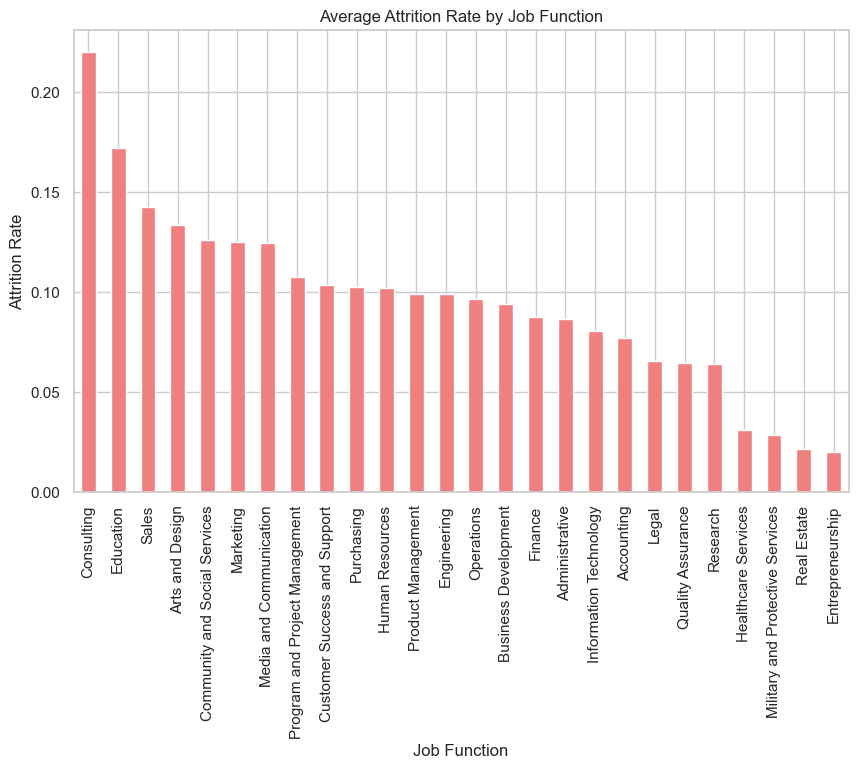

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot function-based attrition
plt.figure(figsize=(10, 6))
function_attrition.sort_values(ascending=False).plot(kind='bar', color='lightcoral')
plt.title('Average Attrition Rate by Job Function')
plt.xlabel('Job Function')
plt.ylabel('Attrition Rate')
plt.xticks(rotation=90)
plt.show()


In [83]:
combined_data_rf.head(5)

,Location,Employees,1y growth,1y hires,Job posts,% of employees,HUGO BOSS %,company_name,sheet_name,Company,...,Your company,Attrition Difference,Hire-to-Departure Ratio,Positive Growth,company_name_encoded,sheet_name_encoded,Location Net Change,Function Net Change,Function Attrition,Location Attrition
0,"London Area, United Kingdom",2151.0,0.023798,361.0,3.0,0.242804,0.043446,Burberry,Locations,NaN,...,NaN,NaN,1.25,True,0,8,106.0,NaN,NaN,0.122841
1,Greater Leeds Area,482.0,0.061674,74.0,1.0,0.054408,0.001835,Burberry,Locations,NaN,...,NaN,NaN,1.25,True,0,8,42.0,NaN,NaN,0.102100
2,New York City Metropolitan Area,475.0,-0.004193,67.0,7.0,0.053618,0.027668,Burberry,Locations,NaN,...,NaN,NaN,1.25,False,0,8,39.0,NaN,NaN,0.109042
3,Hong Kong SAR,277.0,0.014652,32.0,2.0,0.031268,0.006238,Burberry,Locations,NaN,...,NaN,NaN,1.25,True,0,8,21.0,NaN,NaN,0.101958
4,Greater Paris Metropolitan Region,269.0,0.097959,92.0,1.0,0.030365,0.028035,Burberry,Locations,NaN,...,NaN,NaN,1.25,True,0,8,24.0,NaN,NaN,0.166518


In [84]:
def extract_hugo_boss_attrition_by_function(all_data):
    results = []

    # Iterate over all files and sheets
    for file_name, sheets in all_data.items():
        for sheet_name, df in sheets.items():
            # Check if the required columns are present in the sheet
            if 'Function' in df.columns and 'HUGO BOSS attrition' in df.columns:
                # Filter rows where the company is 'HUGO BOSS'
                hugo_boss_rows = df[df['Company'] == 'HUGO BOSS'] if 'Company' in df.columns else df

                # Group by 'Function' and calculate the average attrition
                grouped = hugo_boss_rows.groupby('Function')['HUGO BOSS attrition'].mean().reset_index()
                results.append(grouped)

    # Concatenate all results into a single DataFrame
    if results:
        combined_df = pd.concat(results, ignore_index=True)

        # Group by 'Function' again to remove duplicates and take the mean if necessary
        combined_df = combined_df.groupby('Function').mean().reset_index()

        # Sort the DataFrame by attrition rate in descending order
        return combined_df.sort_values(by='HUGO BOSS attrition', ascending=False)

    else:
        return pd.DataFrame(columns=['Function', 'HUGO BOSS attrition'])

# Extract Hugo Boss's attrition rate by function
hugo_boss_attrition_by_function_df = extract_hugo_boss_attrition_by_function(all_data)

# Display the top 5 functions with the highest attrition rate
print(hugo_boss_attrition_by_function_df.head(29))


                            Function  HUGO BOSS attrition
24                          Research             0.520231
7                          Education             0.400000
5                         Consulting             0.242424
12                   Human Resources             0.238849
25                             Sales             0.204139
14                             Legal             0.198198
15                         Marketing             0.195794
6       Customer Success and Support             0.186495
16           Media and Communication             0.182306
10                           Finance             0.165680
1                     Administrative             0.158672
8                        Engineering             0.142589
18                        Operations             0.137232
13            Information Technology             0.120079
2                    Arts and Design             0.114890
4      Community and Social Services             0.112903
20    Program 

### Convert to csv file

In [85]:
hugo_boss_attrition_by_function_df.to_csv('Hugo_Boss_attrition_by function.csv',index=False)